# Use a model trained on 2020 data to predict for 2019 train

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
torch.cuda.is_available()

True

In [3]:
from argparse import Namespace

In [4]:
from cassava.lmdb_dataset import *
from cassava.utils import *
from cassava.transforms import get_test_transforms

In [5]:
from cassava.models.model import LeafDoctorModel

In [6]:
from cassava.pipelines.train_model.nodes import score_model

In [7]:
parameters = context.catalog.load('parameters')

2020-12-23 14:27:51,693 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...


In [8]:
parameters

{'seed': 42,
 'cv_splits': 4,
 'cv_models_dir': 'data/06_models/cv_folds',
 'validation_size': 0.1,
 'data_loader_workers': 6,
 'classifier': {'gpus': -1,
  'batch_size': 32,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'early_stop_patience': 4,
  'reduce_lr_on_pleteau_patience': 2,
  'save_top_k_checkpoints': 1,
  'checkpoints_dir': 'data/06_models/classifier/checkpoints',
  'limit_train_batches': 1000,
  'amp_level': 'O2',
  'precision': 16},
 'byol': {'gpus': -1,
  'batch_size': 24,
  'accumulate_grad_batches': 1,
  'max_epochs': 100,
  'max_steps': 0,
  'auto_lr_find': 0,
  'lr': 0.001,
  'reduce_lr_on_pleteau_patience': 1,
  'weight_decay': 0.0001,
  'limit_train_batches': 100,
  'limit_val_batches': 1,
  'early_stop_patience': 3,
  'amp_level': '02',
  'precision': 16,
  'on_test': {'lr': 0.0001,
   'auto_lr_find': 0,
   'max_epochs': 5,
   'early_stop_patience': 1}},
 'eval': {'batch_size': 16}}

In [9]:
train_lmdb = context.catalog.load('train_lmdb')

2020-12-23 14:27:51,740 - kedro.io.data_catalog - INFO - Loading data from `train_lmdb` (KedroImageLMDBDataSet)...


In [38]:
train_labels = context.catalog.load('train_labels')

2020-12-23 14:31:15,378 - kedro.io.data_catalog - INFO - Loading data from `train_labels` (CSVDataSet)...


In [43]:
duplicates = context.catalog.load('duplicates')

2020-12-23 14:32:13,904 - kedro.io.data_catalog - INFO - Loading data from `duplicates` (CSVDataSet)...


In [49]:
train_labels = train_labels.drop(duplicates[duplicates.ds2 == 'train_2020'].id2.values)

In [51]:
train_2020_indices = np.array(range(len(train_lmdb)))[train_lmdb.sources == 'train_2020']

In [52]:
train_2019_indices = np.array(range(len(train_lmdb)))[train_lmdb.sources == 'train_2019']

In [53]:
assert len(train_labels) == len(train_2020_indices), (len(train_labels), len(train_2020_indices))

In [15]:
pd.Series(train_lmdb.labels[train_2019_indices]).value_counts(normalize=True)

3    0.466275
1    0.260685
2    0.127810
0    0.082034
4    0.063196
dtype: float64

In [16]:
unnorm = Unnormalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

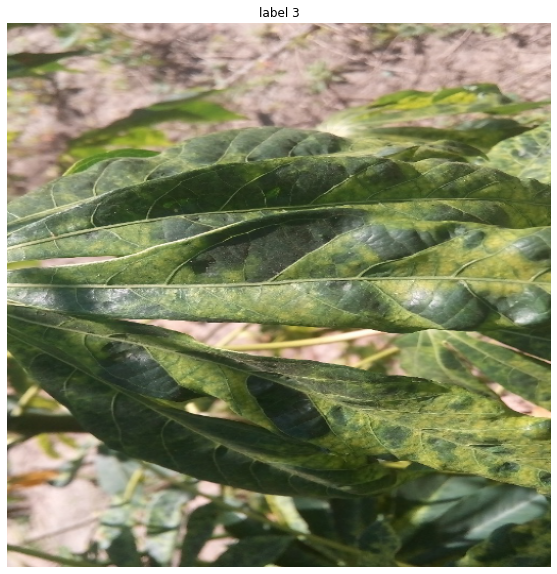

In [138]:
idx = np.random.choice(train_2019_indices)
img, label = train_lmdb[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}')
plt.show()

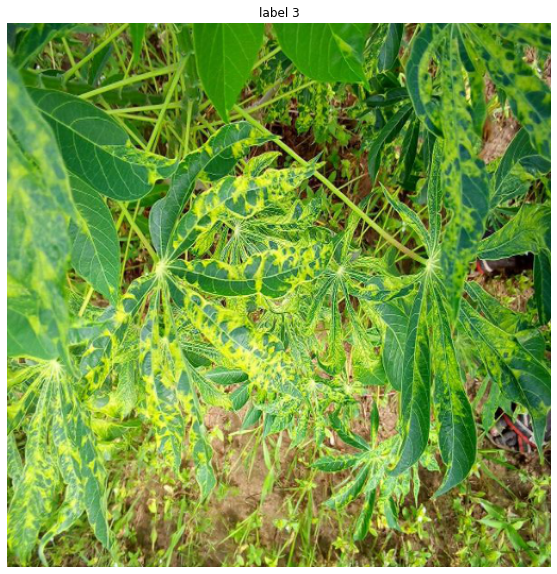

In [160]:
idx = np.random.choice(train_2020_indices)
img, label = train_lmdb[idx]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}')

# Train model on 2020 data

In [54]:
from cassava.pipelines.train_model.nodes import split_data, train_model

In [55]:
train_indices, val_indices = split_data(train_labels, parameters)

In [60]:
assert not set(train_indices).intersection(train_2019_indices)

In [61]:
hparams = Namespace(**parameters['classifier'])
model = LeafDoctorModel(hparams)

In [63]:
model = train_model(model, train_lmdb, train_indices, val_indices, parameters)

GPU available: True, used: True


2020-12-23 14:34:48,171 - lightning - INFO - GPU available: True, used: True


TPU available: False, using: 0 TPU cores


2020-12-23 14:34:48,172 - lightning - INFO - TPU available: False, using: 0 TPU cores


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


2020-12-23 14:34:48,173 - lightning - INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Using native 16bit precision.


2020-12-23 14:34:48,174 - lightning - INFO - Using native 16bit precision.



  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


2020-12-23 14:34:48,330 - lightning - INFO - 
  | Name  | Type         | Params
---------------------------------------
0 | trunk | EfficientNet | 4.0 M 


Epoch 0: val_acc reached 0.84439 (best 0.84439), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8444.ckpt as top 1


2020-12-23 14:54:29,191 - lightning - INFO - Epoch 0: val_acc reached 0.84439 (best 0.84439), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=0_val_acc=0.8444.ckpt as top 1


Epoch 1: val_acc reached 0.85187 (best 0.85187), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8519.ckpt as top 1


2020-12-23 15:14:14,093 - lightning - INFO - Epoch 1: val_acc reached 0.85187 (best 0.85187), saving model to /home/boris/Documents/kaggle cassava/cassava/notebooks/data/06_models/classifier/checkpoints/epoch=1_val_acc=0.8519.ckpt as top 1


/home/boris/Documents/kaggle cassava/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)
Epoch 2: val_acc was not in top 1


2020-12-23 15:15:03,656 - lightning - INFO - Epoch 2: val_acc was not in top 1

2020-12-23 15:15:03,933 - root - INFO - Training finished


# Obtain model scores on 2019 train

In [64]:
score, preds = score_model(model, train_lmdb, train_2019_indices, parameters)

2020-12-23 15:15:05,865 - root - INFO - Scoring model



2020-12-23 15:19:00,327 - root - INFO - Validation scores:
{'accuracy': 0.5993518330970224, 'f1_score': 0.5764170325805427}


In [65]:
score

{'accuracy': 0.5993518330970224, 'f1_score': 0.5764170325805427}

In [66]:
from sklearn.metrics import accuracy_score, confusion_matrix

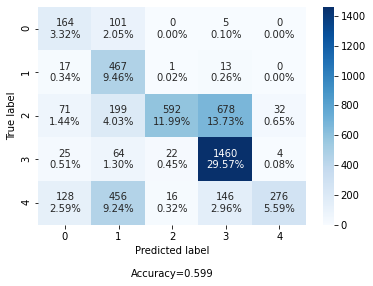

In [67]:
make_confusion_matrix(confusion_matrix(preds, train_lmdb.labels[train_2019_indices]))

In [68]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [79]:
def get_test_transforms():
    return A.Compose([
        A.ToFloat(max_value=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])



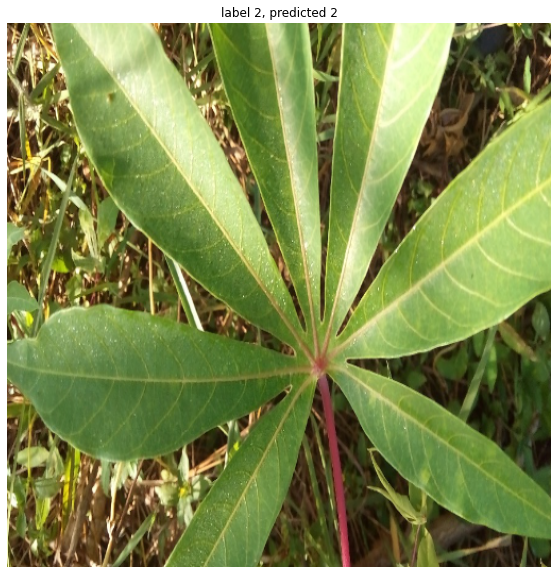

In [137]:
idx = np.random.choice(train_2019_indices)
img, label = train_lmdb[idx]
predicted = preds[np.argwhere(train_2019_indices == idx)[0][0]]
plt.figure(figsize=(10, 10))
plot_image(unnorm(get_test_transforms()(image=img)['image']), label=f'label {label}, predicted {predicted}')
plt.show()